## To re-run notebook, click 'Kernel'-> 'Restart Kernel and Run all cells'
## expected run time is ~1 hour
## scroll to bottom of notebook to see result plots

In [1]:
!pip install pandas matplotlib numpy sklearn 
import sys
import warnings
import os,sys,re,logging,datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import builtins

warnings.simplefilter(action='ignore', category=FutureWarning)
TEST=False
DEBUG=False

In [2]:
from lib.Result import Result
from lib.functions import *

In [3]:
print(sys.executable)
for p in ["/home/jovyan/work/data/demo/","/home/jovyan/data/demo/"]:
    if os.path.exists(p):
        dataDir=p
print(dataDir)
builtins.stageDir=dataDir+"stage/"
if not os.path.exists(stageDir):
    import pathlib
    pathlib.Path(stageDir).mkdir(parents=True, exist_ok=True)
    


/opt/conda/bin/python
/home/jovyan/work/data/demo/


# Input files and mapping

In [4]:
'''
numFeatures.csv is a csv file of numerical feature vectors.
Each row corresponds to a single patient
'patient_num' is a mandatory column for patient number (used as primary key or index)
binary variables represented with 0 or 1 values
categorical variables are represented as a set of binary mutually exclusive variables/columns
numerical variaables can have integer or float values
'''
numDf=pd.read_csv(dataDir+"numFeatures.csv").set_index('patient_num')


'''
labels.csv is a csv file of numerical vector indicating disease/phenotype label.
'''


labelDf=pd.read_csv(dataDir+"labels.csv").set_index('patient_num')
idx_all=numDf.index.values
labels=list(labelDf.columns)


'''
dxCodeMap is a dictionary that maps the label (disease/phenotype column name in label.csv)
to the diagnostic-count variable (column name in numFeatures.csv)
This map is needed for creating the polar silver standard sets
and also for the base-line 'dxCount' classifier
'''

dxCodeMap={'Asthma_GoldStandardLabel':'Asthma_COD_DX_Asthma',
          'BrCa_GoldStandardLabel':'BrCa_COD_DX_Breastcancer',
          'COPD_GoldStandardLabel':'COPD_COD_DX_COPD',
          'Depression_GoldStandardLabel':'Depression_COD_DX_Depression',
          'Epilepsy_GoldStandardLabel':'Epilepsy_COD_DX_Epilepsy',
          'HTN_GoldStandardLabel':'HTN_COD_DX_Hypertension',
          }

print(labels)


['Asthma_GoldStandardLabel', 'BrCa_GoldStandardLabel', 'COPD_GoldStandardLabel', 'Depression_GoldStandardLabel', 'Epilepsy_GoldStandardLabel', 'HTN_GoldStandardLabel']


In [5]:
#checks for input integrity
assert(len(numDf.index.values)==len(labelDf.index.values))
for i in range(0,len(numDf.index.values)):
    assert(numDf.index.values[i]==labelDf.index.values[i])


# Run experiment

In [14]:
#import shutil
#shutil.rmtree( stageDir+"result", ignore_errors=True)

nRun=15
clsNames=['LogisticRegression','RandomForestClassifier']
test_train_ratio=0.5

if True:
    resArr=[]

    std="dxCount"
    Result.delete_result(std)
    for run in range(0,nRun):
        try:
            resArr=[]
            
            for labelx in labels:

                startTime=datetime.datetime.now()
                testIdx,nonTestIdx,label=getIdx_Test_NonTest(labelDf,idx_all,label=labelx,frac=test_train_ratio)
               
                dxCodeName=dxCodeMap[label] 
                trainX,trainXcols=getFeatM(numDf,nonTestIdx)
                #print(trainX)
                trainY=getLabelV(labelDf,label,nonTestIdx)       
                trainDf=pd.DataFrame(trainX,columns=trainXcols)


                testX,testXcols=getFeatM(numDf,testIdx)
                testDf=pd.DataFrame(testX,columns=testXcols)

                predProb=getPred_dxCount(testDf,trainDf,trainDf,dxCodeName)
                
                print('Run:',str(run),' of ',str(nRun), '  std:',std,' for label:',labelx)
                s=getScore(testIdx,labelDf,labelx,predProb)
                an={}
                an["run"]=run
                import datetime
                an["dt"]=datetime.datetime.now()
                an["start_dt"]=startTime
                an["runtime_ms"]=(datetime.datetime.now()-startTime).total_seconds()*1000
                an["std"]=std
                an["cla"]='-'
                an['trainSize']=None
                s_with_a={**s, **an}
                resArr.append(s_with_a)
            Result.save_result(std,resArr,asPercent=True)
        except Exception as e:
            error(e)
            
            
if True:
    std='gold' 
    Result.delete_result(std)
    for run in range(0,nRun):
        try:
            
            for cla in clsNames:
                resArr=[]
                
                for labelx in labels:

                    testIdx,nonTestIdx,label=getIdx_Test_NonTest(_labelDf=labelDf,_idx_all=idx_all,label=labelx,frac=test_train_ratio)
                    selIdx,an1=getIdx_TrainAnno(_labelDf=labelDf,nonTestIdx=nonTestIdx,label=label)

                    trainX,trainXcols=getFeatM(_numDf=numDf,idx=selIdx)
                    trainY=getLabelV(labelDf,label,selIdx)       
                    trainDf=pd.DataFrame(trainX,columns=trainXcols)

                    testX,testXcols=getFeatM(_numDf=numDf,idx=testIdx)
                    testDf=pd.DataFrame(testX,columns=testXcols)
                    
                    (predProb,an)=getPred_ML(cla,testDf,trainDf, trainLabelV=trainY)
                    an["run"]=run
                    an["std"]=std
                    #an["TrainNNone"]=True

                    #debug(an)
                    #print(run,alg,algN,labelx)
                    print('Run:',run,' of ',nRun, '  std:',std, ' Classifier:',cla,' for label:',labelx)
                    s=getScore(testIdx,labelDf,labelx,predProb)
                    s_with_a={**s, **an,**an1}
                    resArr.append(s_with_a)
                Result.save_result(std,resArr,asPercent=True)
                
        except Exception as e:
            error(e)
            raise e
            
            
if True:
    std='silver'
    Result.delete_result(std)
    resArr=[]
    for run in range(0,nRun):
        for trainN in [8000]:
            for selFactor in [0.5]:
                try:
                    for cla in clsNames:
                        resArr=[]
                       
                        for labelx in labels:
                            import datetime
                            dxCodeName=dxCodeMap[labelx] 
                            
                            testIdx,nonTestIdx,label=getIdx_Test_NonTest(_labelDf=labelDf,_idx_all=idx_all,label=labelx,frac=test_train_ratio)
                            labelIdx=getLabelIdx(_labelDf=labelDf,label=labelx)
                            # select ids for nonLabelled set
                            selIdx=[x for x in nonTestIdx if x not in labelIdx]

                            trainX,trainXcols=getFeatM(_numDf=numDf,idx=selIdx)
                            trainY=getLabelV(labelDf,label,selIdx)      
                            trainDf=pd.DataFrame(trainX,columns=trainXcols)

                            testX,testXcols=getFeatM(_numDf=numDf,idx=testIdx)
                            testDf=pd.DataFrame(testX,columns=testXcols)


                            (predProb,an)=getPred_SilverPolar_ML(cla,testDf=testDf,trainDf=trainDf, dxCodeName=dxCodeName,trainN=trainN,selFactor=selFactor)
                            print(run,std,cla,labelx)
                            s=getScore(testIdx,labelDf,labelx,predProb)
                            an["run"]=run
                            an["std"]=std
                            #debug(an)
                            s_with_a={**s, **an}
                            resArr.append(s_with_a)
                        Result.save_result(std,resArr,asPercent=True)
                        

                except Exception as e:
                    error(e)
                    raise e

Deleting result: dxCount
saved result for :dxCount   0 /home/jovyan/work/data/demo/stage/result/dxCount.csv
Deleting result: gold
saved result for :gold   0 /home/jovyan/work/data/demo/stage/result/gold.csv
Deleting result: silver
saved result for :silver   0 /home/jovyan/work/data/demo/stage/result/silver.csv


# Read result

In [15]:
#array of standards includiing dxCount Baseline
stdA=["dxCount","gold",'silver']
metric='roc_auc'
pdfArr=[]
for std in stdA:
    try:
        pdfArr.append(Result.read_result(std))
    except Exception as e:
        pass
pdfR=pd.concat(pdfArr,sort=False)
pdfR=pdfR.reset_index(drop=True)

pdf=pdfR[((pdfR['std']==stdA[2])& (pdfR['trainSize']==8000)& (pdfR['selFactor']==0.5))|\
        (pdfR['std']==stdA[0])|(pdfR['std']==stdA[1])]

metricLabel={'roc_auc':'AUROC'}

#dictionary for plots labels
labelExpanded={
 'Asthma':'Asthma' ,
"BrCa":'Breast cancer',
'COPD':'COPD',
'Depression':'Depression',
"Epilepsy":"Epilepsy",
'HTN':'Hypertension'}

labelDf=pd.read_csv(dataDir+"labels.csv").set_index('patient_num')

labels=list([ x for x in labelDf.columns if 'Gold' in x])
           

# Draw AUROC comparison plots

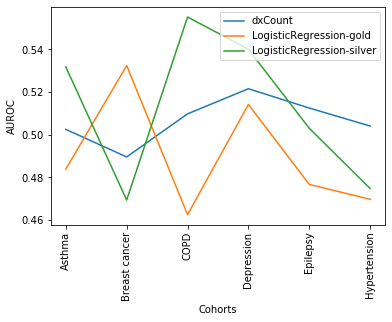

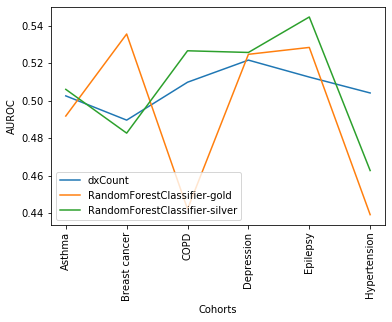

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
labelsShort=[re.sub("_GoldStandardLabel",'',x) for x in labels]


for selCl in clsNames:
    legendArr=[]
    
    #dxcount
    legendArr.append(stdA[0])
    cond=( (pdf['std']==stdA[0])  )
    x=pdf[cond].groupby(['label'])[metric].mean()
    plt.plot(x.index.values,list(x),alpha=1.0)
    
    #gold and silver
    for std in stdA[1:3]:
        clsN=selCl
        #print(std,clsN)
        cond=( (pdf['std']==std) & (pdf['cla']==selCl) )
        x=pdf[cond].groupby(['label'])[metric].mean()
        plt.plot(x.index.values,list(x),alpha=1.0);
        legendArr.append(clsN+'-'+std)


    plt.xticks(rotation=90)
    plt.xticks(range(0,len(labels)), [ labelExpanded[x] for x in list(x.index.values)])#, size='small')
    plt.legend(legendArr)
    plt.xlabel("Cohorts")
    plt.ylabel(metricLabel[metric])

    plt.show()

# Comparison across the Gold and Silver arms of the experiment for a particular classifier. Classification based on diagnostic count is included as baseline


for cla: LogisticRegression


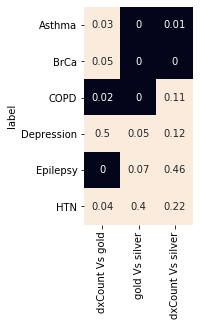


for cla: RandomForestClassifier


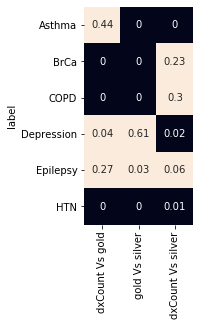

In [13]:

for cla in clsNames:
    print('\nfor cla:',cla)
    finalRes=pdf
    gRes={}
    
    for algName in stdA:
        res={}
        x1=finalRes['cla'].isin(['RandomForestClassifier'])
        x2=pd.isnull(finalRes['cla'])
        a=finalRes[(finalRes['std']==algName)  & (finalRes['cla'].isin([cla,'-']))]


        for label in labelsShort:
            cond=(a["label"]==label)
            list_metric=list(a[cond][metric])
            res[label]={}
            res[label]["list"]=list_metric
            res[label]["n"]=len(list_metric)
            res[label]['mean']=np.mean(list_metric)
            res[label]['sd']=np.std(list_metric)
            #print(res)
        gRes[algName]=res

    def compareAlg(gRes,alg0,alg1):
        cmpStr=alg0+" Vs " +alg1
        #print("comparing "+cmpStr)
        r=gRes
        arr=[]
        arr1=[]
        for label in labelsShort:
            from scipy import stats
            d1=r[alg0][label]
            d2=r[alg1][label]
            tup=(label,d1["n"],d1["mean"],d1["sd"]\
                        ,d2["n"],d2["mean"],d2["sd"]\
                       ,stats.ttest_ind(d1["list"],d2["list"]))
            arr.append(tup)
            arr1.append((tup[0],tup[7][1]))
        a1=pd.DataFrame(arr,columns=["label","n1",'m1','sd1',"n2",'m2','sd2','t-test'])
        a2=pd.DataFrame(arr1,columns=["label",cmpStr])
        a2=a2.set_index("label")
        return a1,a2[[cmpStr]]


    hm1=compareAlg(gRes,stdA[0],stdA[1])[1]
    hm2=compareAlg(gRes,stdA[1],stdA[2])[1]
    hm3=compareAlg(gRes,stdA[0],stdA[2])[1]


    hm=pd.concat([hm1,hm2,hm3],axis=1,ignore_index=False)

    import seaborn as sns
    hm=hm.apply(lambda x:round(x,2))
    sns.heatmap(hm, annot=True, annot_kws={"size": 10},square=True,vmin=0.02,vmax=0.03,cbar=False)
    plt.show()


    m_arr=[]
    for label in sorted(labelsShort):
        m_arr.append([label,round(gRes[stdA[0]][label]['mean']*100,1),round(gRes[stdA[1]][label]['mean']*100,1),round(gRes[stdA[2]][label]['mean']*100,1)])

    pd.DataFrame(m_arr,columns=['label']+stdA)